## Naive Tokenization using a fixed Vocabulary

We need tokenization to represent text as something we can put into our neural networks. This process turns the most common words into integers. These integers can then be embedded using one hot encoding (a very poor choice) or by training an embedding layer as we train our network (or use a pretrained one). For a fixed vocabulary of size VOCAB_SIZE and a neural network with input_dim INPUT_DIM, our embedding layer would learn VOCAB_SIZE embeddings of size INPUT_DIM.

Check out [Andrej Karpathy's Tokenizer video](https://youtu.be/zduSFxRajkE?si=GH3Pw76Mh_pUUezL) if you want to learn more

In [22]:
import re
from urllib import request

import numpy as np
from matplotlib import pyplot as plt

In [23]:


hamlet = request.urlopen("https://www.gutenberg.org/files/1524/1524-0.txt").read().decode('utf-8')

def clean_and_split(text:str)->list[str]:
    text = re.sub(r'[^\w\s,\.]', '', text) # remove non-alphanumeric
    text = re.sub(r'[^\w]|[\r\n]+', ' ', text) # replace commas and periods with space
    text = text.strip() # remove spaces in the beginning and end

    return [word.lower() for word in text.split(" ") if word]

hamlet = clean_and_split(hamlet)

In [24]:
" ".join(hamlet)

'the project gutenberg ebook of hamlet by william shakespeare this ebook is for the use of anyone anywhere in the united states and most other parts of the world at no cost and with almost no restrictions whatsoever you may copy it give it away or reuse it under the terms of the project gutenberg license included with this ebook or online at www gutenberg org if you are not located in the united states you will have to check the laws of the country where you are located before using this ebook title hamlet author william shakespeare release date november 1998 ebook 1524 most recently updated november 9 2023 language english produced by dianne bean start of the project gutenberg ebook hamlet cover the tragedy of hamlet prince of denmark by william shakespeare contents act i scene i elsinore a platform before the castle scene ii elsinore a room of state in the castle scene iii a room in poloniuss house scene iv the platform scene v a more remote part of the castle act ii scene i a room i

Space will not be a token here but we will use it later (because after each and every token we can place a space)

In [25]:
counts = {}
for word in hamlet:
    if not word: continue # skip spaces

    word = word.lower()
    counts[word] = counts.get(word, 0) + 1 # defaults to 0 if word is not in the dictionary yet


In [26]:
num_words = sum(counts.values())
sorted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)


In [27]:
np.cumsum([x[1] for x in sorted_counts]).max(), num_words

(35301, 35301)

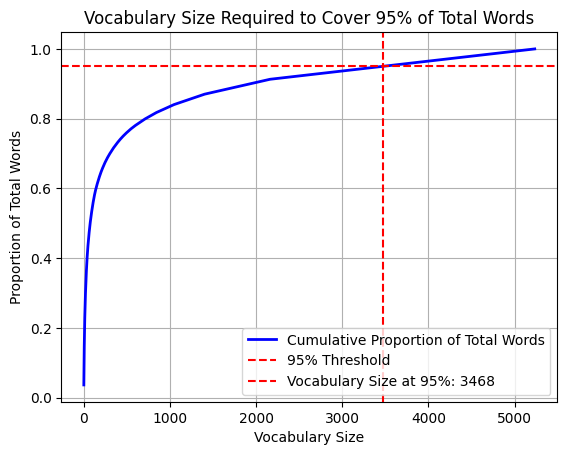

In [28]:
vocabulary_size = np.cumsum([x[1] for x in sorted_counts]) / num_words
threshold_index = np.argmax(vocabulary_size >= 0.95)  # Index where cumulative sum reaches or exceeds 95%


plt.plot(vocabulary_size, label='Cumulative Proportion of Total Words', color='blue', linestyle='-', linewidth=2)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Threshold')
plt.axvline(x=threshold_index, color='r', linestyle='--', label=f'Vocabulary Size at 95%: {threshold_index}')
plt.xlabel('Vocabulary Size')
plt.ylabel('Proportion of Total Words')
plt.title('Vocabulary Size Required to Cover 95% of Total Words')
plt.grid(True)
plt.legend()

plt.show()

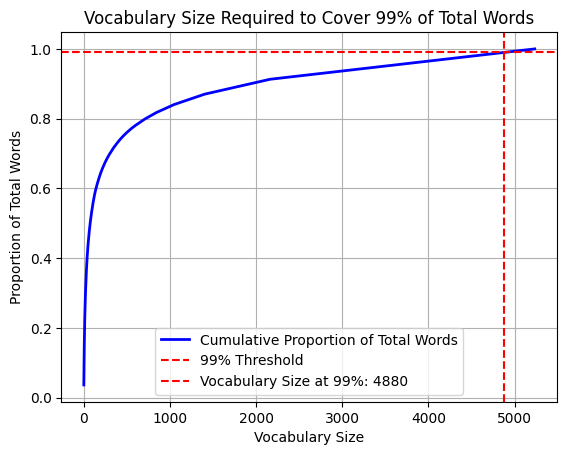

In [29]:
vocabulary_size = np.cumsum([x[1] for x in sorted_counts]) / num_words
threshold_index = np.argmax(vocabulary_size >= 0.99)  # Index where cumulative sum reaches or exceeds 99%


plt.plot(vocabulary_size, label='Cumulative Proportion of Total Words', color='blue', linestyle='-', linewidth=2)
plt.axhline(y=0.99, color='r', linestyle='--', label='99% Threshold')
plt.axvline(x=threshold_index, color='r', linestyle='--', label=f'Vocabulary Size at 99%: {threshold_index}')
plt.xlabel('Vocabulary Size')
plt.ylabel('Proportion of Total Words')
plt.title('Vocabulary Size Required to Cover 99% of Total Words')
plt.grid(True)
plt.legend()

plt.show()

In [30]:
VOCAB_SIZE = 1024
SPECIAL_TOKENS = ["<BOS>", "<EOS>", "<UNK>"] # beginning of sentence, end of sentence, unknown

vocab = SPECIAL_TOKENS + [x[0] for x in sorted_counts[:(VOCAB_SIZE - len(SPECIAL_TOKENS))]]
word_to_idx = {x: i for i, x in enumerate(vocab)}
idx_to_word = {i: x for i, x in enumerate(vocab)}

Now we can tokenize Hamlet

In [31]:
sentence = "something is rotten in the state of denmark"
sentence

'something is rotten in the state of denmark'

In [32]:
def tokenize(sentence:str)->list[int]:
    words = clean_and_split(sentence)
    return [word_to_idx.get(word, word_to_idx["<UNK>"]) for word in words]

tokenize(sentence)

[291, 15, 2, 11, 3, 219, 6, 193]

In [33]:
def detokenize(tokens:list[int])->str:
    return " ".join(idx_to_word[t] for t in tokens)

detokenize(tokenize(sentence))

'something is <UNK> in the state of denmark'

In [34]:
sentence = """This above all: to thine own self be true,
And it must follow, as the night the day,
Thou canst not then be false to any man."""

print(clean_and_split(sentence))
print(tokenize(sentence))
print(detokenize(tokenize(sentence)))

['this', 'above', 'all', 'to', 'thine', 'own', 'self', 'be', 'true', 'and', 'it', 'must', 'follow', 'as', 'the', 'night', 'the', 'day', 'thou', 'canst', 'not', 'then', 'be', 'false', 'to', 'any', 'man']
[16, 908, 43, 5, 322, 135, 2, 23, 207, 4, 13, 80, 214, 25, 3, 141, 3, 224, 53, 2, 17, 90, 23, 646, 5, 116, 111]
this above all to thine own <UNK> be true and it must follow as the night the day thou <UNK> not then be false to any man


## BPE

Can be done on words, subwords or characters. In all cases you do the same thing. Find the two most common pairs, and replace them with a single token. Perhaps "to the" is very common in Hamlet and therefore we could treat that pair as a single token (to and the are still tokens).

This increases the the amount of different tokens we have while reducing the length of the tokenized text. This is a great trade-off for RNNs and Transformers which can suffer from longer sequences (for RNNs, the information of a token in it's hidden state severely degregades over the sequence, Transformers have a "quadratic time complexity w.r.t. the length of the input sequence / context window"). 

In [35]:
hamlet = request.urlopen("https://www.gutenberg.org/files/1524/1524-0.txt").read().decode('utf-8')
hamlet = re.sub('[\ufeff\r]', '', hamlet) # replace \ufeff\r with ''
hamlet = re.sub('[\n]', ' ', hamlet) # replace newline with space
hamlet[:100]

'The Project Gutenberg eBook of Hamlet, by William Shakespeare  This eBook is for the use of anyone a'

In [36]:
hamlet_ascii = [ord(x) for x in hamlet]
"".join(chr(o) for o in hamlet_ascii[:100])

'The Project Gutenberg eBook of Hamlet, by William Shakespeare  This eBook is for the use of anyone a'

In [37]:
len(set(hamlet_ascii)), min(hamlet_ascii), max(hamlet_ascii) # ascii is easy but annoying that it doesnt start at 0 and end at #unique_characters

(91, 32, 8482)

In [38]:
chr_to_ids = {c:i for i,c in enumerate(set(hamlet))}
ids_to_chr = {i:c for c,i in chr_to_ids.items()}

hamlet_ids = [chr_to_ids[x] for x in hamlet]

def most_common_pair(ids:list[int])->tuple[int,int]:
    counts = {}
    for a, b in zip(ids[:-1], ids[1:]):
        counts[(a,b)] = counts.get((a,b), 0) + 1
    return max(counts.items(), key=lambda x: x[1])

In [39]:
pair, count = most_common_pair(hamlet_ids)
ids_to_chr[pair[0]], ids_to_chr[pair[1]]


('e', ' ')

The most common pair is 'e' and ' ' which makes sense, a lot of words end with 'e' and are most often followed by a space

In [40]:
def replace_pair(ids:list[int], pair:tuple[int,int])->list[int]:
    new_id = max(ids) + 1
    new_ids = []
    i = 0
    while i < len(ids):
        if i < len(ids) - 1 and ids[i] == pair[0] and ids[i+1] == pair[1]:
            new_ids.append(new_id)
            i += 2 # we accounted for two tokens
        else:
            new_ids.append(ids[i])
            i += 1
    
    return new_ids

new_hamlet_ids = replace_pair(hamlet_ids, pair)
len(new_hamlet_ids), len(hamlet_ids), max(new_hamlet_ids), max(hamlet_ids)

(192162, 197001, 91, 90)

In [41]:
def bpe(text:str, iterations:int)->tuple[list[int], dict[int, str]]:
    ids_to_chr = {i:c for i,c in enumerate(set(text))}
    chr_to_ids = {c:i for i,c in ids_to_chr.items()}

    ids = [chr_to_ids[x] for x in text]
    for _ in range(iterations):
        pair, _ = most_common_pair(ids)
        ids = replace_pair(ids, pair)
        ids_to_chr[max(ids_to_chr) + 1] = ids_to_chr[pair[0]] + ids_to_chr[pair[1]]

    return ids, ids_to_chr


ids, ids_to_chr = bpe(hamlet, 1)

ids_to_chr[len(ids_to_chr) - 1] # the newest minted token is 'e '

'e '

In [42]:
ids, ids_to_chr = bpe(hamlet, 1000)
chr_to_ids = {c:i for i,c in ids_to_chr.items()}

In [43]:
len(ids), len(hamlet), f"{1-len(ids)/len(hamlet):.2%} shorter with a vocab of size {len(ids_to_chr)}"

(67723, 197001, '65.62% shorter with a vocab of size 1091')

In [44]:
ids_to_chr[len(ids_to_chr) - 1] # the newest minted token is 'foo'

'foo'

In [45]:
ids_to_chr[len(ids_to_chr) - 2] # the second newest minted token is 'ity '

'ity '

Colorizing the tokens helps visualize it well, a lighter color theme helps here.

In [46]:
RESET_BG = '\x1b[0m'  # ANSI code to reset background color
COLORS = [
    (194, 224, 255),  # light blue
    (255, 218, 194),  # light orange
    (194, 255, 208),  # light green
    (255, 194, 224),  # light pink
    (218, 255, 194),  # light lime
]

def bg_color(rgb:tuple[int, int, int]) -> str:
    """Return ANSI escape code for a custom RGB background color."""
    return f'\x1b[48;2;{rgb[0]};{rgb[1]};{rgb[2]}m'

def color_print(text:str, color_idx:int):
     color = COLORS[color_idx % len(COLORS)]
     print(bg_color(color) + text, end='')

# this logic can be abstracted into a tokenizer, i.e. look for the longest substring that is contained in our token dictionary
# making a tree of how tokens are joined instead of storing it as a dictionary is probably better
def token_print(text:str, chr_to_ids:dict[str:int]):
    i = 0
    color_idx = 0
    longest_token = max(len(x) for x in chr_to_ids.keys())
    while i < len(text):
        # find the longest substring included in the vocabulary
        token = ""
        token_idx = -1
        for j in range(i + 1, min(len(text)+1, i+longest_token)):
            substring = text[i:j]
            if substring in chr_to_ids:
                token = substring
                token_idx = j - i
            
        if token_idx == -1: raise RuntimeError()

        color_print(token, color_idx)
        i += token_idx
        color_idx += 1


token_print(hamlet[:100], chr_to_ids)
hamlet[:100]

The Project Gutenberg eBook of Hamlet, by William Shakespeare  This eBook is for the use of anyone a

'The Project Gutenberg eBook of Hamlet, by William Shakespeare  This eBook is for the use of anyone a'

In [47]:
"Th" in chr_to_ids, "e " in chr_to_ids, "The" in chr_to_ids, "The " in chr_to_ids

(True, True, False, True)

Here the tokens "Th" and "e " were merged but not "Th" and "e" (or other permutation). Makes sense.

In [27]:
"Project Gutenberg" in chr_to_ids

True

What is missing?

* a way to fit the BPE to some text and then transform another
    * now we only have a one way mapping ids_to_chr
* introducing subwords first? Maybe unnecessary
* perhaps Python keywords are common enough for BPE to simply create them

## Tokenizing python code (Mix of both)
Create fixed token representation for things like keywords and parentheses while doing BPE on the characters in:

* variables
* variable names
* function names
* comments
* etc

This is not strictly necessary but I believe it will help since we will be training quite small models. Will probably also reduce the amount of synxtax errors. 

Should we include the python keywords in the BPE?

We can use python's tokenize module to easily split any python function into something we can then tokenize

### How about we only do BPE?

In [28]:
import inspect
import torch
torch_src = inspect.getsource(torch)

torch_src[3000:3100]

"join(os.path.dirname(__file__), 'lib')\n\n    # When users create a virtualenv that inherits the base "

In [29]:
ids, ids_to_chr_100 = bpe(torch_src, 100)
chr_to_ids_100 = {c:i for i,c in ids_to_chr_100.items()}
print(len(ids), len(torch_src), f"{1-len(ids)/len(torch_src):.2%} shorter with a vocab of size {len(ids_to_chr_100)}")
token_print(torch_src[-4850:-4408], chr_to_ids_100)

45873 79997 42.66% shorter with a vocab of size 194
me = '.'.join([__name__, device_type])
    sys.modules[torch_module_name] = module

# expose return_types
from . import return_types
from . import library
if not TYPE_CHECKING:
    from . import _meta_registrations

# Enable CUDA Sanitizer
if 'TORCH_CUDA_SANITIZER' in os.environ:
    import torch.cuda._sanitizer as csan

    csan.enable_cuda_sanitizer()

# Populate magic methods on SymInt and SymFloat
import torch.fx.experimental.sym_node

In [30]:
ids, ids_to_chr_1000 = bpe(torch_src, 1000)
chr_to_ids_1000 = {c:i for i,c in ids_to_chr_1000.items()}
print(len(ids), len(torch_src), f"{1-len(ids)/len(torch_src):.2%} shorter with a vocab of size {len(ids_to_chr_1000)}")
token_print(torch_src[-4850:-4408], chr_to_ids_1000)

21019 79997 73.73% shorter with a vocab of size 1094
me = '.'.join([__name__, device_type])
    sys.modules[torch_module_name] = module

# expose return_types
from . import return_types
from . import library
if not TYPE_CHECKING:
    from . import _meta_registrations

# Enable CUDA Sanitizer
if 'TORCH_CUDA_SANITIZER' in os.environ:
    import torch.cuda._sanitizer as csan

    csan.enable_cuda_sanitizer()

# Populate magic methods on SymInt and SymFloat
import torch.fx.experimental.sym_node

In [31]:
ids, ids_to_chr_2000 = bpe(torch_src, 2000)
chr_to_ids_2000 = {c:i for i,c in ids_to_chr_2000.items()}
print(len(ids), len(torch_src), f"{1-len(ids)/len(torch_src):.2%} shorter with a vocab of size {len(ids_to_chr_2000)}")
token_print(torch_src[-4850:-4408], chr_to_ids_2000)

15127 79997 81.09% shorter with a vocab of size 2094
me = '.'.join([__name__, device_type])
    sys.modules[torch_module_name] = module

# expose return_types
from . import return_types
from . import library
if not TYPE_CHECKING:
    from . import _meta_registrations

# Enable CUDA Sanitizer
if 'TORCH_CUDA_SANITIZER' in os.environ:
    import torch.cuda._sanitizer as csan

    csan.enable_cuda_sanitizer()

# Populate magic methods on SymInt and SymFloat
import torch.fx.experimental.sym_node

In [32]:
ids, ids_to_chr_3000 = bpe(torch_src, 3000)
chr_to_ids_3000 = {c:i for i,c in ids_to_chr_3000.items()}
print(len(ids), len(torch_src), f"{1-len(ids)/len(torch_src):.2%} shorter with a vocab of size {len(ids_to_chr_3000)}")
token_print(torch_src[-4850:-4408], chr_to_ids_3000)

12124 79997 84.84% shorter with a vocab of size 3094
me = '.'.join([__name__, device_type])
    sys.modules[torch_module_name] = module

# expose return_types
from . import return_types
from . import library
if not TYPE_CHECKING:
    from . import _meta_registrations

# Enable CUDA Sanitizer
if 'TORCH_CUDA_SANITIZER' in os.environ:
    import torch.cuda._sanitizer as csan

    csan.enable_cuda_sanitizer()

# Populate magic methods on SymInt and SymFloat
import torch.fx.experimental.sym_node

In [37]:
"i" in chr_to_ids_3000, "im" in chr_to_ids_3000, "imp" in chr_to_ids_3000, "i" in chr_to_ids_3000, "impo" in chr_to_ids_3000, "impor" in chr_to_ids_3000, "import" in chr_to_ids_3000

(True, False, True, True, False, True, True)

In [38]:
"torch" in chr_to_ids_3000, "print" in chr_to_ids_3000

(True, True)

Seems like BPE does a good enough job. It is pretty overfit to pytorch specific stuff with 3000 iterations but we will use a subset of our training data to 'fit' the BPE so it should be pretty general.

### Handling python keywords

We can't simply add vocabulary["import"] = 1095 because that violates the assumption BPE makes that if "import" is a token then e.g. "imp" and "ort" must be a token (or other combination)

In [39]:
import tokenize

tokenize.EQUAL, ord("=") # not ascii

(22, 61)

In [40]:
from io import BytesIO


python_code = """
# sum from 1 to 9
accumulator = 0 # accumulates the sum
for i in range(10):
    accumulator += 1
"""

list(x.string for x in tokenize.tokenize(BytesIO(python_code.encode("utf-8")).readline)) # don't know why utf-8 is there

['utf-8',
 '\n',
 '# sum from 1 to 9',
 '\n',
 'accumulator',
 '=',
 '0',
 '# accumulates the sum',
 '\n',
 'for',
 'i',
 'in',
 'range',
 '(',
 '10',
 ')',
 ':',
 '\n',
 '    ',
 'accumulator',
 '+=',
 '1',
 '\n',
 '',
 '']